This notebook is used to run JAX-CANOAK in US-Hn1 site.

# Load the necessary libraries

In [1]:
# # TODO: A more generic way is needed here to load the path
# import sys

# sys.path.append(
#     "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
#     # "/global/homes/p/peishi89/jax-watershed/src"
# )

In [2]:
import time

from typing import List

import optax
import equinox as eqx

import torch
from torch.utils.data import Dataset, DataLoader

from sklearn import preprocessing

import numpy as np
import jax
import jax.numpy as jnp

from jax_canoak.subjects import get_met_forcings, get_obs
from jax_canoak.shared_utilities.plot import get_time
from jax_canoak.shared_utilities import compute_metrics

import matplotlib.pyplot as plt
from jax_canoak.shared_utilities.plot import (
    plot_timeseries_obs_1to1,
)

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
jax.config.update("jax_debug_infs", False)

%load_ext autoreload
%autoreload 2

In [3]:
small_size = 15
medium_size = 25
bigger_size = 30
plt.rc("font", size=small_size)  # controls default text sizes
plt.rc("axes", titlesize=small_size)  # fontsize of the axes title
plt.rc("axes", labelsize=small_size)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
plt.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
plt.rc("legend", fontsize=small_size)  # legend fontsize
plt.rc("figure", titlesize=small_size)  # fontsize of the figure title
plt.rc("text", usetex=False)

# Files / directories / DL hyperparameters

In [4]:
site, key = "US-Wkg", "dl"

# Calibration period
f_forcing = f"../../data/fluxtower/{site}/{site}-forcings.csv"
f_obs = f"../../data/fluxtower/{site}/{site}-fluxes.csv"

# Test period
f_forcing_test = f"../../data/fluxtower/{site}/{site}-forcings-test.csv"
f_obs_test = f"../../data/fluxtower/{site}/{site}-fluxes-test.csv"

In [5]:
# Hyperparameters
batch_size = 64
initial_lr = 2e-1
nsteps = 500
seed = 5678

key = jax.random.PRNGKey(seed)

# Load forcings and outputs

In [6]:
varns = [
    "T_air",
    "rglobal",
    "eair",
    "wind",
    "CO2",
    "P_kPa",
    "ustar",
    "soilmoisture",
    "lai",
]

In [7]:
# Calibration period
met, n_time = get_met_forcings(f_forcing)
timesteps = get_time(met)
obs = get_obs(f_obs)
x = np.array(
    [
        met.T_air,
        met.rglobal,
        met.eair,
        met.wind,
        met.CO2,
        met.P_kPa,
        met.ustar,
        met.soilmoisture,
        met.lai,
    ]
).T
y = obs.LE
y = np.expand_dims(y, axis=-1)

/global/homes/p/peishi89/jax-watershed/src/jax_canoak/subjects/initialization_update.py:270: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  obs.interpolate(method="linear", limit_direction="both", inplace=True)


In [8]:
# Test period
met_test, n_time_test = get_met_forcings(f_forcing_test)
timesteps_test = get_time(met_test)
obs_test = get_obs(f_obs_test)
x_test = np.array(
    [
        met_test.T_air,
        met_test.rglobal,
        met_test.eair,
        met_test.wind,
        met_test.CO2,
        met_test.P_kPa,
        met_test.ustar,
        met_test.soilmoisture,
        met_test.lai,
    ]
).T
y_test = obs_test.LE
y_test = np.expand_dims(y_test, axis=-1)

/global/homes/p/peishi89/jax-watershed/src/jax_canoak/subjects/initialization_update.py:270: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  obs.interpolate(method="linear", limit_direction="both", inplace=True)


# Normalize the data

In [9]:
scaler_x = preprocessing.StandardScaler().fit(x)
scaler_y = preprocessing.StandardScaler().fit(y)

In [10]:
x_norm = scaler_x.transform(x)
y_norm = scaler_y.transform(y)
x_test_norm = scaler_x.transform(x_test)
y_test_norm = scaler_y.transform(y_test)

In [11]:
# x_norm = jax.nn.standardize(x,axis=0)
# y_norm = jax.nn.standardize(y,axis=0)
# x_test_norm = jax.nn.standardize(x_test,axis=0)
# y_test_norm = jax.nn.standardize(y_test,axis=0)

# MLP

## Create dataset and dataloader

In [12]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        # Return the size of the dataset, which is the length of one of the arrays
        return len(self.x)

    def __getitem__(self, idx):
        # Retrieve and return the corresponding elements from both arrays
        sample1 = self.x[idx]
        sample2 = self.y[idx]
        return sample1, sample2

In [13]:
# train_dataset = CustomDataset(x_norm, y_norm)
# test_dataset = CustomDataset(x_test_norm, y_test_norm)
train_dataset = CustomDataset(np.array(x_norm), np.array(y_norm))
test_dataset = CustomDataset(np.array(x_test_norm), np.array(y_test_norm))
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)

## Train a MLP model

In [14]:
# Define a deep learning model
n_input, n_output = x.shape[1], y.shape[1]
model = eqx.nn.MLP(n_input, n_output, 6, 6, activation=jax.nn.tanh, key=key)

In [15]:
# Training setup
scheduler = optax.piecewise_constant_schedule(
    initial_lr, boundaries_and_scales={50: 0.1, 100: 0.1, 200: 0.1}
)
# scheduler = optax.constant_schedule(initial_lr)
optim = optax.adam(learning_rate=scheduler)  # Adam optimizer

In [16]:
# Loss function
@eqx.filter_jit
def loss_func(model, x_batch, y_batch):
    pred_y_batch = jax.vmap(model)(x_batch)
    return jnp.mean((y_batch - pred_y_batch) ** 2)

In [17]:
opt_state = optim.init(eqx.filter(model, eqx.is_array))


@eqx.filter_jit
def make_step(model, opt_state, x_batch, y_batch):
    loss_value, grads = eqx.filter_value_and_grad(loss_func)(model, x_batch, y_batch)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


loss_train_all = []
loss_test_all = []
for step in range(nsteps):
    start_time = time.time()
    for x_batch_tensor, y_batch_tensor in trainloader:
        x_batch, y_batch = jnp.array(x_batch_tensor), jnp.array(y_batch_tensor)
        model, opt_state, loss_batch = make_step(model, opt_state, x_batch, y_batch)
    epoch_time = time.time() - start_time

    loss_train = loss_func(model, x_norm, y_norm)
    loss_test = loss_func(model, x_test_norm, y_test_norm)
    loss_train_all.append(loss_train)
    loss_test_all.append(loss_test)
    print("Epoch {} in {:0.2f} sec".format(step, epoch_time))
    # print("Training set loss: {}".format(loss_train))
    # print("Test set loss {}".format(loss_test))

Epoch 0 in 2.43 sec
Epoch 1 in 1.24 sec
Epoch 2 in 1.11 sec
Epoch 3 in 1.09 sec
Epoch 4 in 1.10 sec
Epoch 5 in 1.08 sec
Epoch 6 in 1.08 sec
Epoch 7 in 1.07 sec
Epoch 8 in 1.12 sec
Epoch 9 in 1.14 sec
Epoch 10 in 1.16 sec
Epoch 11 in 1.13 sec
Epoch 12 in 1.13 sec
Epoch 13 in 1.13 sec
Epoch 14 in 1.14 sec
Epoch 15 in 1.16 sec
Epoch 16 in 1.14 sec
Epoch 17 in 1.13 sec
Epoch 18 in 1.13 sec
Epoch 19 in 1.13 sec
Epoch 20 in 1.13 sec
Epoch 21 in 1.13 sec
Epoch 22 in 1.13 sec
Epoch 23 in 1.13 sec
Epoch 24 in 1.20 sec
Epoch 25 in 1.19 sec
Epoch 26 in 1.13 sec
Epoch 27 in 1.14 sec
Epoch 28 in 1.13 sec
Epoch 29 in 1.13 sec
Epoch 30 in 1.13 sec
Epoch 31 in 1.15 sec
Epoch 32 in 1.16 sec
Epoch 33 in 1.15 sec
Epoch 34 in 1.13 sec
Epoch 35 in 1.13 sec
Epoch 36 in 1.13 sec
Epoch 37 in 1.14 sec
Epoch 38 in 1.16 sec
Epoch 39 in 1.15 sec
Epoch 40 in 1.17 sec
Epoch 41 in 1.15 sec
Epoch 42 in 1.13 sec
Epoch 43 in 1.13 sec
Epoch 44 in 1.12 sec
Epoch 45 in 1.12 sec
Epoch 46 in 1.13 sec
Epoch 47 in 1.13 sec
Ep

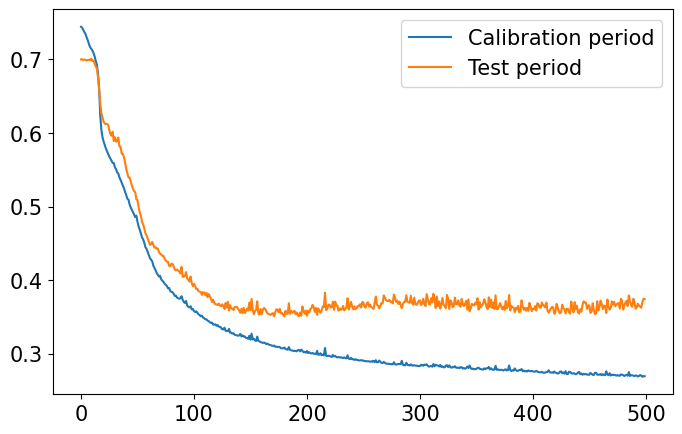

In [28]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(loss_train_all, label="Calibration period")
ax.plot(loss_test_all, label="Test period")
ax.legend()

# LSTM

## Create dataset and dataloader

In [34]:
n_step_lstm = 12  # 6hr

y_lstm, y_test_lstm = y[n_step_lstm - 1 : -1], y_test[n_step_lstm - 1 : -1]

# Reorganize the data to be fitted into the LSTM model
x_norm_lstm = np.array(
    [x_norm[i : i + n_step_lstm, :] for i in range(n_time - n_step_lstm)]
)
y_norm_lstm = np.array(y_norm[n_step_lstm - 1 : -1, :])
x_test_norm_lstm = np.array(
    [x_test_norm[i : i + n_step_lstm, :] for i in range(n_time_test - n_step_lstm)]
)
y_test_norm_lstm = np.array(y_test_norm[n_step_lstm - 1 : -1, :])

In [27]:
# train_dataset = CustomDataset(x_norm, y_norm)
# test_dataset = CustomDataset(x_test_norm, y_test_norm)
train_lstm_dataset = CustomDataset(np.array(x_norm_lstm), np.array(y_norm_lstm))
test_lstm_dataset = CustomDataset(
    np.array(x_test_norm_lstm), np.array(y_test_norm_lstm)
)
trainloader_lstm = torch.utils.data.DataLoader(
    train_lstm_dataset, batch_size=batch_size, shuffle=True
)
testloader_lstm = torch.utils.data.DataLoader(
    test_lstm_dataset, batch_size=batch_size, shuffle=True
)

## Train a LSTM model

In [28]:
class LSTM(eqx.Module):
    # cell_layers: List[eqx.nn.LSTMCell]
    cell_layer: eqx.nn.LSTMCell
    output_layer: eqx.nn.MLP

    def __init__(self, input_size, hidden_size, output_size, key):
        # self.cell_layers = [eqx.nn.LSTMCell(input_size, hidden_size) for i in range(n_cell)]
        self.cell_layer = eqx.nn.LSTMCell(input_size, hidden_size, key=key)
        self.output_layer = eqx.nn.MLP(
            hidden_size,
            output_size,
            int((hidden_size + output_size) / 2),
            1,
            activation=jax.nn.tanh,
            key=key,
        )

    def __call__(self, xs):
        scan_fn = lambda state, input: (self.cell_layer(input, state), None)
        init_state = (
            jnp.zeros(self.cell_layer.hidden_size),
            jnp.zeros(self.cell_layer.hidden_size),
        )
        final_state, _ = jax.lax.scan(scan_fn, init_state, xs)
        hidden_state = final_state[0]
        output = self.output_layer(hidden_state)
        return output

In [29]:
n_input, n_output, n_hidden = x.shape[-1], y.shape[-1], 10
model2 = LSTM(n_input, n_hidden, n_output, key)

In [30]:
# Training setup
scheduler = optax.piecewise_constant_schedule(
    initial_lr, boundaries_and_scales={50: 0.1, 100: 0.1, 200: 0.1}
)
# scheduler = optax.constant_schedule(initial_lr)
optim = optax.adam(learning_rate=scheduler)  # Adam optimizer

In [31]:
# Loss function
@eqx.filter_jit
def loss_func(model, x_batch, y_batch):
    pred_y_batch = jax.vmap(model)(x_batch)
    return jnp.mean((y_batch - pred_y_batch) ** 2)

In [33]:
opt_state = optim.init(eqx.filter(model2, eqx.is_array))


@eqx.filter_jit
def make_step(model, opt_state, x_batch, y_batch):
    loss_value, grads = eqx.filter_value_and_grad(loss_func)(model, x_batch, y_batch)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


loss_lstm_train_all = []
loss_lstm_test_all = []
for step in range(nsteps):
    start_time = time.time()
    for x_batch_tensor, y_batch_tensor in trainloader_lstm:
        x_batch, y_batch = jnp.array(x_batch_tensor), jnp.array(y_batch_tensor)
        model2, opt_state, loss_batch = make_step(model2, opt_state, x_batch, y_batch)
    epoch_time = time.time() - start_time

    loss_train = loss_func(model2, x_norm_lstm, y_norm_lstm)
    loss_test = loss_func(model2, x_test_norm_lstm, y_test_norm_lstm)
    loss_lstm_train_all.append(loss_train)
    loss_lstm_test_all.append(loss_test)
    print("Epoch {} in {:0.2f} sec".format(step, epoch_time))

Epoch 0 in 1.16 sec
Epoch 1 in 0.41 sec
Epoch 2 in 0.42 sec
Epoch 3 in 0.41 sec
Epoch 4 in 0.42 sec
Epoch 5 in 0.43 sec
Epoch 6 in 0.41 sec
Epoch 7 in 0.42 sec
Epoch 8 in 0.41 sec
Epoch 9 in 0.41 sec
Epoch 10 in 0.40 sec
Epoch 11 in 0.41 sec
Epoch 12 in 0.42 sec
Epoch 13 in 0.41 sec
Epoch 14 in 0.40 sec
Epoch 15 in 0.41 sec
Epoch 16 in 0.42 sec
Epoch 17 in 0.41 sec
Epoch 18 in 0.43 sec
Epoch 19 in 0.42 sec
Epoch 20 in 0.43 sec
Epoch 21 in 0.41 sec
Epoch 22 in 0.41 sec
Epoch 23 in 0.42 sec
Epoch 24 in 0.44 sec
Epoch 25 in 0.41 sec
Epoch 26 in 0.41 sec
Epoch 27 in 0.41 sec
Epoch 28 in 0.41 sec
Epoch 29 in 0.41 sec
Epoch 30 in 0.40 sec
Epoch 31 in 0.41 sec
Epoch 32 in 0.40 sec
Epoch 33 in 0.41 sec
Epoch 34 in 0.41 sec
Epoch 35 in 0.41 sec
Epoch 36 in 0.40 sec
Epoch 37 in 0.40 sec
Epoch 38 in 0.40 sec
Epoch 39 in 0.41 sec
Epoch 40 in 0.40 sec
Epoch 41 in 0.40 sec
Epoch 42 in 0.40 sec
Epoch 43 in 0.39 sec
Epoch 44 in 0.40 sec
Epoch 45 in 0.40 sec
Epoch 46 in 0.41 sec
Epoch 47 in 0.41 sec
Ep

# Predictions on both training and test datasets

In [18]:
def l2_func(y, y_true):
    return np.mean((y - y_true) ** 2)

In [19]:
# Sensitivity analysis
def model_scaler(x, model):
    return model(x)[0]

## MLP

### Sensitivity analysis

In [20]:
grad = jax.vmap(jax.grad(model_scaler), in_axes=[0, None])(x_norm, model)
grad_test = jax.vmap(jax.grad(model_scaler), in_axes=[0, None])(x_test_norm, model)

In [21]:
# fig, axes = plt.subplots(len(varns), 1, figsize = (20, 20))
# for i,ax in enumerate(axes):
#     ax.plot(grad[:,i])
#     ax.set(ylabel=varns[i])
# # grad.mean(axis=0), grad_test.mean(axis=0)

In [22]:
# fig, axes = plt.subplots(len(varns), 1, figsize = (20, 20))
# for i,ax in enumerate(axes):
#     ax.plot(grad_test[:,i])
#     ax.set(ylabel=varns[i])
# # grad.mean(axis=0), grad_test.mean(axis=0)

### Predictions

In [23]:
pred_y_norm_calib = jax.vmap(model)(x_norm)
pred_y_norm_test = jax.vmap(model)(x_test_norm)

pred_y_calib = scaler_y.inverse_transform(pred_y_norm_calib)
pred_y_test = scaler_y.inverse_transform(pred_y_norm_test)

l2_calib = l2_func(pred_y_calib, y)
l2_test = l2_func(pred_y_test, y_test)

In [24]:
metrics = compute_metrics(pred_y_calib, y)
metrics_test = compute_metrics(pred_y_test, y_test)
print(metrics)
print(metrics_test)

{'rmse': 20.909543587810933, 'mse': 437.2090130505653, 'r2': 0.7294475128482509, 'kge': 0.8485931445497974, 'nse': 0.7758901828277638, 'mkge': 0.8325040264387328, 'cc': 0.8814817661433492, 'alpha': 1.0283075308273695, 'beta': 0.8850782305166055}
{'rmse': 22.017621917418104, 'mse': 484.7756748983701, 'r2': 0.46749343732563176, 'kge': 0.674819963550226, 'nse': 0.7235636146260026, 'mkge': 0.7373734363978754, 'cc': 0.8640383962900512, 'alpha': 0.9044107673530333, 'beta': 0.7966533677976356}


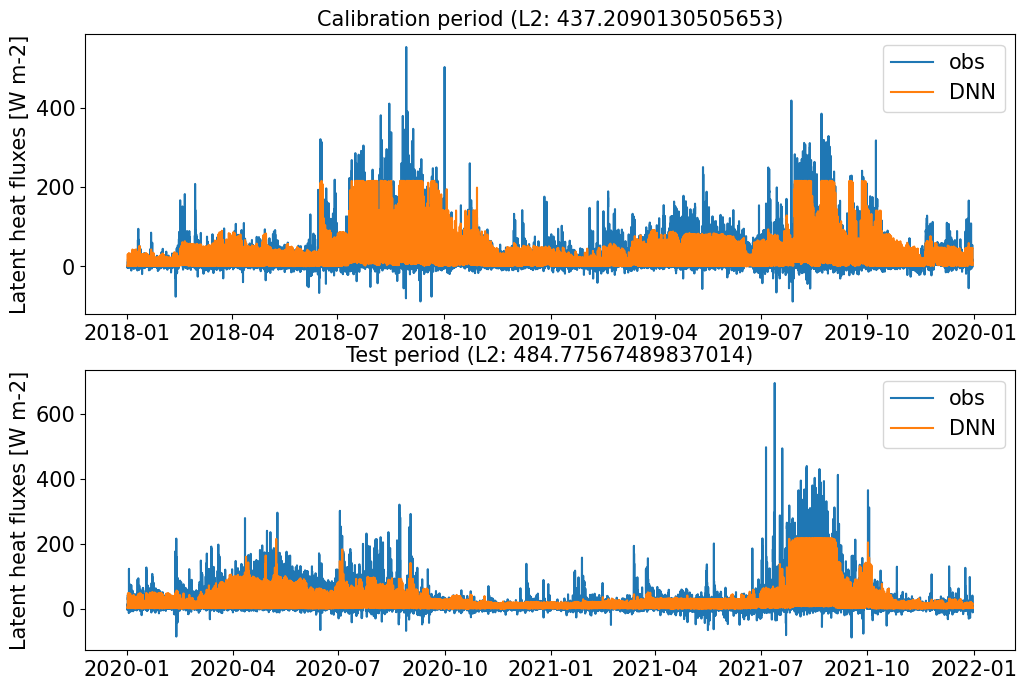

In [25]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
ax = axes[0]
ax.plot(timesteps, y, label="obs")
ax.plot(timesteps, pred_y_calib, label="DNN")
ax.set(
    title=f"Calibration period (L2: {l2_calib})", ylabel="Latent heat fluxes [W m-2]"
)
ax.legend()

ax = axes[1]
ax.plot(timesteps_test, y_test, label="obs")
ax.plot(timesteps_test, pred_y_test, label="DNN")
ax.set(title=f"Test period (L2: {l2_test})", ylabel="Latent heat fluxes [W m-2]")
ax.legend()

### Save the predictions

In [27]:
import pickle

train = {"time": timesteps, "LE": pred_y_calib.flatten()}
test = {"time": timesteps_test, "LE": pred_y_test.flatten()}
out = {"train": train, "test": test}
pickle.dump(out, open(f"{site}_{key}.pkl", "wb"), pickle.HIGHEST_PROTOCOL)


## LSTM

In [40]:
pred_y_norm_lstm_calib = jax.vmap(model2)(x_norm_lstm)
pred_y_norm_lstm_test = jax.vmap(model2)(x_test_norm_lstm)

pred_y_lstm_calib = scaler_y.inverse_transform(pred_y_norm_lstm_calib)
pred_y_lstm_test = scaler_y.inverse_transform(pred_y_norm_lstm_test)

l2_calib_lstm = l2_func(pred_y_lstm_calib, y_lstm)
l2_test_lstm = l2_func(pred_y_lstm_test, y_test_lstm)

ValueError: x and y must have same first dimension, but have shapes (18960,) and (18948, 1)

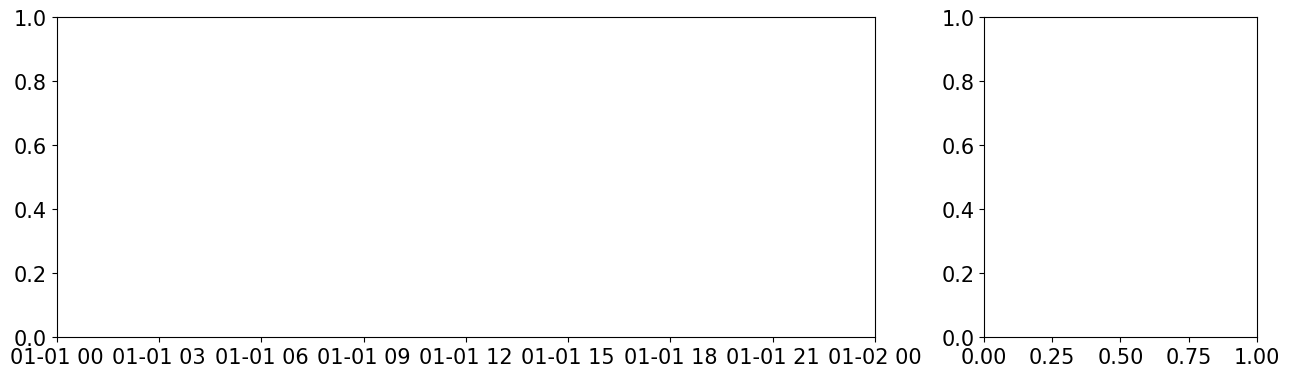

In [43]:
fig, ax1, ax2 = plot_timeseries_obs_1to1(
    y_lstm,
    pred_y_lstm_calib,
    lim=[-150, 350],
    met=met,
    varn="Latent heat fluxes [W m-2]",
    # linestyle=".",
)
# ax1.set(ylabel="[W m-2]")
# ax12 = ax1.twinx()
# ax12.invert_yaxis()
# ax12.plot(timesteps_test, obs_test.P, "k")
# ax12.set(ylim=[10, 0], ylabel="Rainfall [mm]")

In [ ]:
fig, ax1, ax2 = plot_timeseries_obs_1to1(
    y_test_lstm,
    pred_y_lstm_test,
    lim=[-150, 350],
    met=met_test,
    varn="Latent heat fluxes [W m-2]",
    # linestyle=".",
)
ax1.set(ylabel="[W m-2]")
ax12 = ax1.twinx()
ax12.invert_yaxis()
ax12.plot(timesteps_test[n_step_lstm - 1 : -1], obs_test.P, "k")
ax12.set(ylim=[10, 0], ylabel="Rainfall [mm]")


ax = axes[1]
ax.plot(timesteps_test[n_step_lstm - 1 : -1], y_test_lstm, label="obs")
ax.plot(timesteps_test[n_step_lstm - 1 : -1], pred_y_lstm_test, label="DNN")
ax.set(title=f"Test period (L2: {l2_test_lstm})", ylabel="Latent heat fluxes [W m-2]")
ax.legend()

## Plot

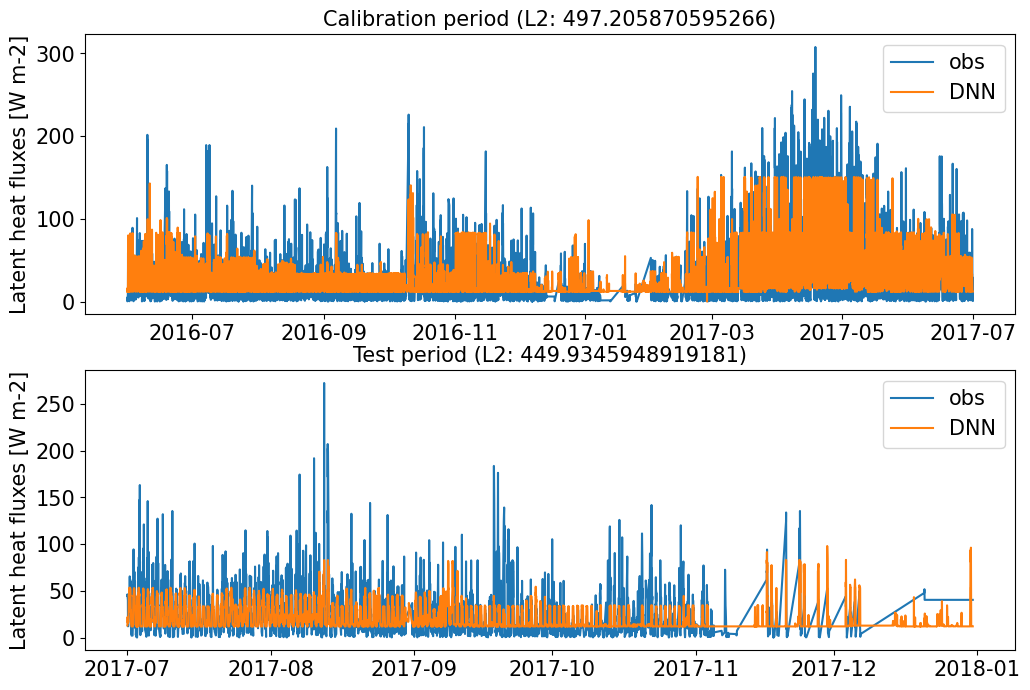

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
ax = axes[0]
ax.plot(timesteps, y, label="obs")
ax.plot(timesteps, pred_y_calib, label="DNN")
ax.set(
    title=f"Calibration period (L2: {l2_calib})", ylabel="Latent heat fluxes [W m-2]"
)
ax.legend()

ax = axes[1]
ax.plot(timesteps_test, y_test, label="obs")
ax.plot(timesteps_test, pred_y_test, label="DNN")
ax.set(title=f"Test period (L2: {l2_test})", ylabel="Latent heat fluxes [W m-2]")
ax.legend()